In [26]:
import numpy as np
from subprocess import Popen, PIPE, call
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from math import isnan
import sys
sys.path.append('../')
from package_global_functions import *

In [8]:
def get_matrix(pi1, pi2, q1, q2, l, sol_index=1):
    '''
    sol_index=1: the program that finds the solution always gets the good one on the second row of the file (when verbosity -v)
    '''
    r1, r2 = 1/q1, 1/q2
    # first get the stationary f0:
    call(f'python f0poly_sols_clean.py {pi1} {pi2} {q1} {q2} {l} -v > sols.dat', shell=True)
    sols = []
    with open('sols.dat', 'r') as file:
        for line in file.readlines():
            sols_i = [float(f) for f in line.split()]
            sols.append(sols_i)
    f0 = sols[sol_index][0] 
    a11 = l*f0-r1-(1-l)*pi1*(1+l/(r1/f0-l))
    a12 = -pi1*(1-l)*(1+l/(r1/f0-l))
    a21 = -pi2*(1-l)*(1+l/(r2/f0-l))
    a22 = l*f0-r2-(1-l)*pi2*(1+l/(r2/f0-l))
    a = np.array([[a11,a12], [a21, a22]])
    return a

def get_matrix_sol_spec(pi1, pi2, q1, q2, l, f0):
    '''
    provide the values of f0
    '''
    r1, r2 = 1/q1, 1/q2
    a11 = l*f0-r1-(1-l)*pi1*(1+l/(r1/f0-l))
    a12 = -pi1*(1-l)*(1+l/(r1/f0-l))
    a21 = -pi2*(1-l)*(1+l/(r2/f0-l))
    a22 = l*f0-r2-(1-l)*pi2*(1+l/(r2/f0-l))
    a = np.array([[a11,a12], [a21, a22]])
    return a

def get_matrix_k_sites(pis, qs, l, sol):
    k = len(pis)
    rows = []
    for i in range(k):
        row_i = []
        for j in range(k):
            if j == i:
                a = l*(sol[0]-sol[i+1]) - (1-l)*pis[i] - 1/qs[i]
            else:
                a = -(1-l)*pis[i] - l*sol[i+1]
            row_i.append(a)
        rows.append(row_i)
    a = np.array(rows)
    return a

In [12]:
# pi1, pi2, q1, q2, l = 0.00001, 0.00001, 10, 10, 0.05
pi1, pi2, q1, q2, l = 0.0, 0.0, 7, 10, 0.1
a = get_matrix(pi1, pi2, q1, q2, l, sol_index=0)
print(np.linalg.eig(a)[0])
eigs = np.linalg.eig(a)[0]

a = get_matrix(pi1, pi2, q1, q2, l, sol_index=1)
print(np.linalg.eig(a)[0])
eigs = np.linalg.eig(a)[0]

a = get_matrix(pi1, pi2, q1, q2, l, sol_index=2)
print(np.linalg.eig(a)[0])
eigs = np.linalg.eig(a)[0]

# a = get_matrix_sol_spec(pi1, pi2, q1, q2, l, f0=0.1)
# print(np.linalg.eig(a)[0])
# eigs = np.linalg.eig(a)[0]

[3.33066907e-16 4.28571429e-02]
[-0.04385714 -0.001     ]
[-4.28571429e-02 -4.67681449e-15]


In [ ]:
np.linalg.eig(a)[1][:,0]

In [ ]:
1/eigs[1]**2

### Let's check that the gneral k matrix works

In [37]:
# pi1, pi2, q1, q2, l = 0.1, 0.1, 7, 10, 0.1
pi1, pi2, q1, q2, l = 0.1, 0.0, 7, 10, 0.1
# the solution for this particular choice of values is:
# fs = [0.31916698712525593, 0.2589229659458394, 0.421910046928904]
fs = [0.5061512185538571, 0.4938487814461411, 0.0]
mat1 = get_matrix(pi1, pi2, q1, q2, l)
mat2 = get_matrix_sol_spec(pi1, pi2, q1, q2, l, fs[0])
mat3 = get_matrix_k_sites((pi1, pi2), (q1, q2), l, fs)
for i in range(2):
    for j in range(2):
        print(mat1[i,j], mat2[i,j], mat3[i,j])

-0.2316268991463713 -0.2316268991463713 -0.23162689914637125
-0.13938487814461423 -0.13938487814461417 -0.13938487814461412
-0.0 -0.0 -0.0
-0.049384878144614244 -0.049384878144614286 -0.049384878144614286


### Stability of solutions for k sites (limit pi2 == 0)

In [10]:
def lambda_change_stab_ksites(pis, qs):
    rs = [1/q for q in qs]
    sumator = 0
    for pi,r in zip(pis[:-1],rs[:-1]):
        sumator += pi/(r-rs[-1])
    return (1+sumator)/(1/rs[-1] + sumator)

In [62]:
# 2 sites:
pis = (0.1, 0.0)
qs = (7.0, 10.0)

# 3 sites:
pis = (0.1,0.1,0.0)
qs = (5.0, 7.0, 10.0)

# 4 sites:
pis = (0.1,0.1,0.1,0.0)
qs = (3.0, 5.0, 7.0, 10.0)

lcs = lambda_change_stab_ksites(pis, qs)
print('lcs = ', lcs)

In [60]:
#above lcs, the solution is:
l = 0.347
fs = []
fs.append(l/qs[-1])
for i in range(len(pis)-1):
    fs.append((pis[i]*(1-l)/qs[-1])/(l*(1/qs[i]-1/qs[-1])))
sumator = 0
for pi,q in zip(pis[:-1],qs[:-1]):
    sumator += pi/(1/q-1/qs[-1])
fs.append(1 - 1/(qs[-1]*l)*(1 + (1-l)*sumator))
print(fs)

mat = get_matrix_k_sites(pis, qs, l, fs)
eigs = np.linalg.eig(mat)[0]
print(eigs)
# OJO: per sota de lcs segueix sent estable, però fk<0!!!

[0.034699999999999995, 0.08065047344586251, 0.18818443804034585, 0.43909702209414053, 0.0038836283793054482]
[-0.64486096 -0.27503025 -0.16290396 -0.0881317 ]


In [53]:
# below the lcs, the solution is:
l = 0.1
callstr = 'python ../more_sites/get_deterministic_solutions.py '
callstr += f"-pis {','.join([str(pi) for pi in pis])} -qs {','.join([str(q) for q in qs])} {l} E" # in order to get the solution with f2=0 above lcs use ic = N
p = Popen(callstr, shell=True, stdin=PIPE, stdout=PIPE, stderr=PIPE)
output, err = p.communicate()
fs = [float(o) for o in output.split(b' ')]
print(fs)

mat = get_matrix_k_sites(pis, qs, l, fs)
eigs, _ = np.linalg.eig(mat)
print(eigs)

[0.4085256524553643, 0.23102671292005594, 0.3604476346245785, 3.021730255126917e-54]
[-0.37157635 -0.12872309 -0.05914743]


## f0 stability case q1=q2, pi1=pi2

In [ ]:
def stability_f0_eq_1(p, q, l):
    r = 1/q
    try:
        func = l-r+2*p*(1-l)*(l+r)/(l-r)
    except ZeroDivisionError:
        print(f'Divide by 0 encountered when p, q, l: {p}, {q}, {l}')
        func = 0.0
    return func

def stability_f0_eq_roverl(p, q, l):
    r = 1/q
    func = -(l-r+2*p*(1-l)*(l+r)/(l-r))
    return func


def stability_f0_eq_1_eps(eps, q, l):
    r = 1/q
    func = l-r+2*eps*(l+r)/(l-r)
    return func

In [ ]:
# explore a renge of pi's, lambdas:
q = 10
pi_lims = (0.0, 0.2)
Npis = 21
l_lims = (0.0, 2/q)
Nls = 21
xgrid_pi, ygrid_l = np.mgrid[pi_lims[0]:pi_lims[1]:complex(0,Npis), l_lims[0]:l_lims[1]:complex(0,Nls)]
xgrid_pi, ygrid_l = np.around(xgrid_pi,4), np.around(ygrid_l,4)
grid_stability = np.empty([Npis, Nls])
for i,pi in enumerate(xgrid_pi[:,0]):
    for j,l in enumerate(ygrid_l[0,:]):
        fstab = stability_f0_eq_1(pi, q, l)
        # if l == 0.1:
        #     print(fstab)
        if fstab == 0.0 or fstab == np.inf or isnan(fstab):
            # print(f'aaaaay: pi = {pi}, l = {l}')
            grid_stability[i,j] = 2 # cumbersome
        elif (fstab < 0):
            grid_stability[i,j] = 1 # stable
        elif (fstab > 0):
            grid_stability[i,j] = 0 # unstable
        # else:
        #     print(f'aaaaay: pi = {pi}, l = {l}')
        #     print(fstab)
        #     grid_stability[i,j] = 2 # cumbersome

In [ ]:
mycmap = ListedColormap(['xkcd:red', 'xkcd:green', 'xkcd:black']) # 0: red, unstable; 1: green, stable
fig, ax = plt.subplots()
im = ax.pcolormesh(xgrid_pi, ygrid_l, grid_stability, vmin=0, vmax=2, cmap=mycmap, shading='nearest')
ax.set(xlabel='$\pi_{1,2}$', ylabel='$\lambda$')

In [ ]:
# explore a renge of epsilon, lambdas:
q = 10
eps_lims = (0.0, 0.001)
Neps = 21
l_lims = (0.0, 2/q)
Nls = 21
xgrid_eps, ygrid_l = np.mgrid[eps_lims[0]:eps_lims[1]:complex(0,Neps), l_lims[0]:l_lims[1]:complex(0,Nls)]
xgrid_eps, ygrid_l = np.around(xgrid_eps,4), np.around(ygrid_l,4)
grid_stability = np.empty([Neps, Nls])
for i,eps in enumerate(xgrid_eps[:,0]):
    for j,l in enumerate(ygrid_l[0,:]):
        fstab = stability_f0_eq_1_eps(eps, q, l)
        # if l == 0.1:
        #     print(fstab)
        if fstab == 0.0 or fstab == np.inf or isnan(fstab):
            # print(f'aaaaay: pi = {pi}, l = {l}')
            grid_stability[i,j] = 2 # cumbersome
        elif (fstab < 0):
            grid_stability[i,j] = 1 # stable
        elif (fstab > 0):
            grid_stability[i,j] = 0 # unstable
        # else:
        #     print(f'aaaaay: pi = {pi}, l = {l}')
        #     print(fstab)
        #     grid_stability[i,j] = 2 # cumbersome

In [ ]:
mycmap = ListedColormap(['xkcd:red', 'xkcd:green', 'xkcd:black']) # 0: red, unstable; 1: green, stable
fig, ax = plt.subplots()
im = ax.pcolormesh(xgrid_eps, ygrid_l, grid_stability, vmin=0, vmax=2, cmap=mycmap, shading='nearest')
ax.set(xlabel='$\epsilon$', ylabel='$\lambda$')

In [ ]:
q, l = 10, 0.05
eps = np.linspace(0.0, 0.1, 50)
fig, ax = plt.subplots()

stab = [stability_f0_eq_1_eps(e, q, l) for e in eps]

ax.plot(eps, stab)
    

# Eigenvalues as characteristic times

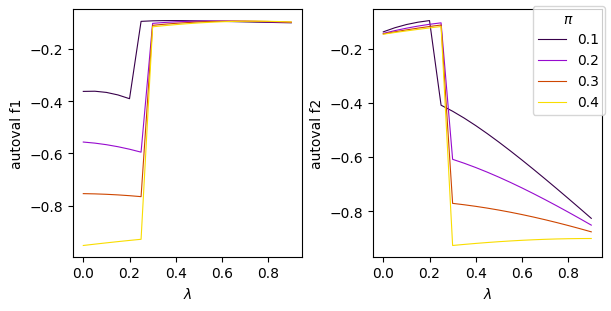

In [6]:
q1, q2 = 5, 10
ls = np.linspace(0.0, 0.9, 19)
pis = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
pis = [0.1, 0.2, 0.3, 0.4]
pis_colors = plt.cm.gnuplot(np.linspace(0.05, 0.95, len(pis)))

fig, ax = plt.subplots(1,2, figsize=(6,3), constrained_layout=True)
ax[0].set(xlabel='$\lambda$', ylabel='autoval f1')
ax[1].set(xlabel='$\lambda$', ylabel='autoval f2')
for p,c in zip(pis, pis_colors):
    avals_f1, avals_f2 = [], []
    for l in ls:
        if l == 0.0:
            mat = get_matrix_sol_spec(p, p, q1, q2, l, 1/(1+p*q1+p*q2))
        else:
            mat = get_matrix(p, p, q1, q2, l, sol_index=1)
        eigs = np.linalg.eig(mat)[0]
        # avals_f1.append(1/abs(eigs[0]))
        # avals_f2.append(1/abs(eigs[1]))
        avals_f1.append(eigs[0])
        avals_f2.append(eigs[1])
    ax[0].plot(ls, avals_f1, label=f'{p}', lw=0.8, color=c)
    ax[1].plot(ls, avals_f2, lw=0.8, color=c)

fig.legend(title='$\pi$')

In [24]:
pi1, pi2, q1, q2, l = 0.1, 0.1, 9, 10, 0.8
a = get_matrix(pi1, pi2, q1, q2, l, sol_index=1)
print(np.linalg.eig(a)[0])
eigs = np.linalg.eig(a)[0]

[-0.01218212 -0.74909617]


In [22]:
1/eigs[0]

-3.187915980437617

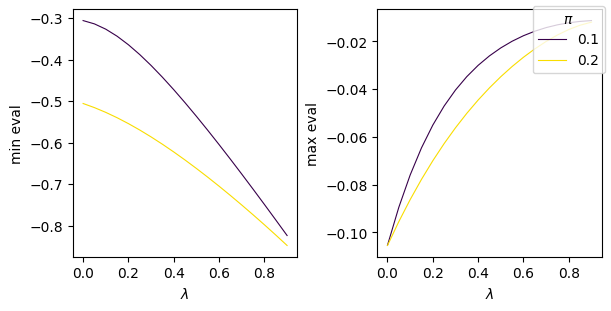

In [3]:
q1, q2 = 9, 10
ls = np.linspace(0.0, 0.9, 19)
pis = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
pis = [0.1, 0.2]
pis_colors = plt.cm.gnuplot(np.linspace(0.05, 0.95, len(pis)))

fig, ax = plt.subplots(1,2, figsize=(6,3), constrained_layout=True)
ax[0].set(xlabel='$\lambda$', ylabel='min eval')
ax[1].set(xlabel='$\lambda$', ylabel='max eval')
for p,c in zip(pis, pis_colors):
    min_evs, max_evs = [], []
    for l in ls:
        if l == 0.0:
            mat = get_matrix_sol_spec(p, p, q1, q2, l, 1/(1+p*q1+p*q2))
        else:
            mat = get_matrix(p, p, q1, q2, l, sol_index=1)
        eigs = np.linalg.eig(mat)[0]
        # avals_f1.append(1/abs(eigs[0]))
        # avals_f2.append(1/abs(eigs[1]))
        min_evs.append(min(eigs))
        max_evs.append(max(eigs))
    ax[0].plot(ls, min_evs, label=f'{p}', lw=0.8, color=c)
    ax[1].plot(ls, max_evs, lw=0.8, color=c)

fig.legend(title='$\pi$')

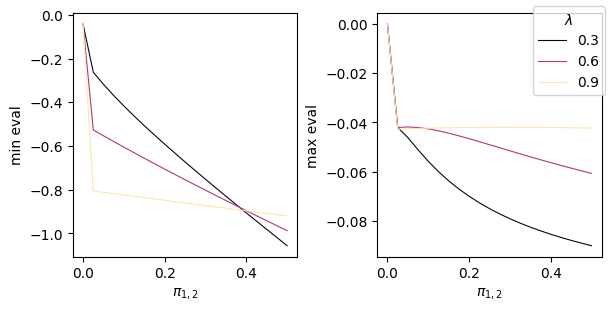

In [20]:
q1, q2 = 7, 10
pis = np.linspace(0.0, 0.5, 21)
ls = [0.3, 0.6, 0.9]
ls_colors = plt.cm.magma(np.linspace(0.05, 0.95, len(ls)))

fig, ax = plt.subplots(1,2, figsize=(6,3), constrained_layout=True)
ax[0].set(xlabel='$\pi_{1,2}$', ylabel='min eval')
ax[1].set(xlabel='$\pi_{1,2}$', ylabel='max eval')
for l,c in zip(ls, ls_colors):
    min_evs, max_evs = [], []
    for p in pis:
        if l == 0.0:
            mat = get_matrix_sol_spec(p, p, q1, q2, l, 1/(1+p*q1+p*q2))
        else:
            mat = get_matrix(p, p, q1, q2, l, sol_index=1)
        eigs = np.linalg.eig(mat)[0]
        # avals_f1.append(1/abs(eigs[0]))
        # avals_f2.append(1/abs(eigs[1]))
        min_evs.append(min(eigs))
        max_evs.append(max(eigs))
    ax[0].plot(pis, min_evs, label=f'{l}', lw=0.8, color=c)
    ax[1].plot(pis, max_evs, lw=0.8, color=c)

fig.legend(title='$\lambda$')

### Characteristic times mesh, symmetric scenario

In [32]:
q1, q2 = 9, 10
path = getExternalSSDpath() + getProjectFoldername() + '/det_sols_from_polynomial/res_files'

# dpi, dl = 0.01, 0.01
# pi_lims = (0.01, 0.5)
# l_lims = (0.00,0.99)

dpi, dl = 0.025, 0.025
pi_lims = (0.025, 0.5)
l_lims = (0.00,0.975)

Npis = int((pi_lims[1] - pi_lims[0])/dpi) + 1
Nls = int((l_lims[1] - l_lims[0])/dl) + 1
xgrid_pi, ygrid_l = np.mgrid[pi_lims[0]:pi_lims[1]:complex(0,Npis), l_lims[0]:l_lims[1]:complex(0,Nls)]
xgrid_pi, ygrid_l = np.around(xgrid_pi,2), np.around(ygrid_l,2)
grid_times = np.empty([2, Npis, Nls])
for i,pi in enumerate(xgrid_pi[:,0]):
    for j,l in enumerate(ygrid_l[0,:]):
        if l == 0.0:
            mat = get_matrix_sol_spec(pi, pi, q1, q2, l, 1/(1+p*q1+p*q2))
        else:
            mat = get_matrix(pi, pi, q1, q2, l, sol_index=1)
        eigs = abs(np.linalg.eig(mat)[0])
        grid_times[0,i,j] = 1/min(eigs)
        grid_times[1,i,j] = 1/max(eigs)

np.savez(f'{path}/map_chartTimes_LSA_sym_q1_{q1}_q2_{q2}.npz', x=xgrid_pi, y=ygrid_l, charTimes=grid_times)

In [33]:
path = getExternalSSDpath() + getProjectFoldername() + '/det_sols_from_polynomial/res_files'
q1, q2 = 9, 10
mapTimes = np.load(f'{path}/map_chartTimes_LSA_sym_q1_{q1}_q2_{q2}.npz')

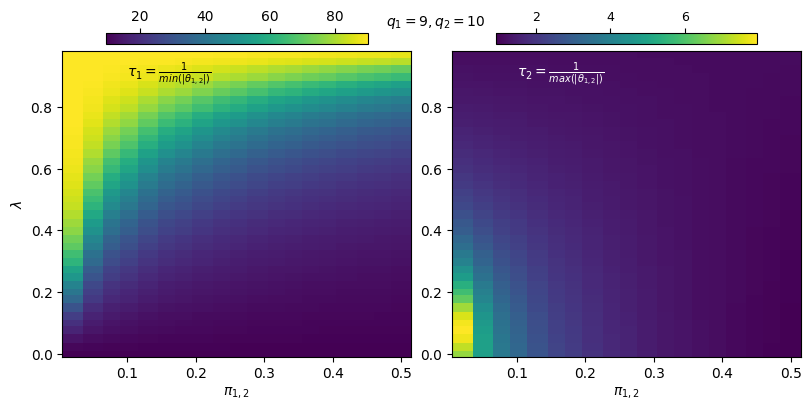

In [34]:
fig, ax = plt.subplots(1,2, figsize=(8, 4), constrained_layout=True)

im = ax[0].pcolormesh(mapTimes['x'], mapTimes['y'], mapTimes['charTimes'][0], cmap='viridis', shading='nearest')
cb = fig.colorbar(im, ax=ax[0], aspect=25, shrink=0.75, pad=0.025, location='top')
ax[0].text(0.1, 0.9, r'$\tau_1 = \frac{1}{min(|\theta_{1,2}|)}$')

im = ax[1].pcolormesh(mapTimes['x'], mapTimes['y'], mapTimes['charTimes'][1], cmap='viridis', shading='nearest')
cb = fig.colorbar(im, ax=ax[1], aspect=25, shrink=0.75, pad=0.025, location='top')
ax[1].text(0.1, 0.9, r'$\tau_2 = \frac{1}{max(|\theta_{1,2}|)}$', color='xkcd:white')

ax[0].set_xlabel('$\pi_{1,2}$')
ax[1].set_xlabel('$\pi_{1,2}$')
ax[0].set_ylabel('$\lambda$')
cb.ax.tick_params(labelsize=9)
fig.text(0.475, 0.95, rf'$q_1 = {q1}, q_2 = {q2}$')
fig.savefig(f'map_chart_times_from_LSA_eigv_sym_q1_{q1}_q2_{q2}.png')

### Characteristic times mesh, asymmetric scenario

In [3]:
q1, q2, pi1 = 7, 10, 0.5
path = getExternalSSDpath() + getProjectFoldername() + '/det_sols_from_polynomial/res_files'

dpi2, dl = 0.01, 0.01
pi2_lims = (0.01, 0.5)
l_lims = (0.00,0.99)

# dpi2, dl = 0.025, 0.025
# pi2_lims = (0.025, 0.5)
# l_lims = (0.00,0.975)

Npi2s = int((pi2_lims[1] - pi2_lims[0])/dpi2) + 1
Nls = int((l_lims[1] - l_lims[0])/dl) + 1
xgrid_pi2, ygrid_l = np.mgrid[pi2_lims[0]:pi2_lims[1]:complex(0,Npi2s), l_lims[0]:l_lims[1]:complex(0,Nls)]
xgrid_pi2, ygrid_l = np.around(xgrid_pi2,2), np.around(ygrid_l,2)
grid_times = np.empty([2, Npi2s, Nls])
for i,pi2 in enumerate(xgrid_pi2[:,0]):
    for j,l in enumerate(ygrid_l[0,:]):
        if l == 0.0:
            mat = get_matrix_sol_spec(pi1, pi2, q1, q2, l, 1/(1+pi1*q1+pi2*q2))
        else:
            mat = get_matrix(pi1, pi2, q1, q2, l, sol_index=1)
        eigs = abs(np.linalg.eig(mat)[0])
        grid_times[0,i,j] = 1/min(eigs)
        grid_times[1,i,j] = 1/max(eigs)

np.savez(f'{path}/map_chartTimes_LSA_asym_fixPi1_pi1_{pi1}_q1_{q1}_q2_{q2}.npz', x=xgrid_pi2, y=ygrid_l, charTimes=grid_times)

In [4]:
path = getExternalSSDpath() + getProjectFoldername() + '/det_sols_from_polynomial/res_files'
q1, q2, pi1 = 7, 10, 0.5
r1, r2 = 1/q1, 1/q2
lcs = r2*(pi1+r1-r2)/(pi1*r2 + r1 - r2)
mapTimes = np.load(f'{path}/map_chartTimes_LSA_asym_fixPi1_pi1_{pi1}_q1_{q1}_q2_{q2}.npz')

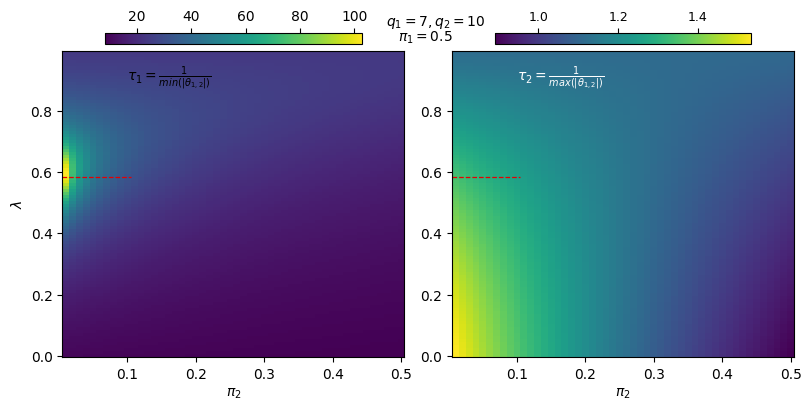

In [5]:
fig, ax = plt.subplots(1,2, figsize=(8, 4), constrained_layout=True)

im = ax[0].pcolormesh(mapTimes['x'], mapTimes['y'], mapTimes['charTimes'][0], cmap='viridis', shading='nearest')
cb = fig.colorbar(im, ax=ax[0], aspect=25, shrink=0.75, pad=0.025, location='top')
ax[0].text(0.1, 0.9, r'$\tau_1 = \frac{1}{min(|\theta_{1,2}|)}$')

im = ax[1].pcolormesh(mapTimes['x'], mapTimes['y'], mapTimes['charTimes'][1], cmap='viridis', shading='nearest')
cb = fig.colorbar(im, ax=ax[1], aspect=25, shrink=0.75, pad=0.025, location='top')
ax[1].text(0.1, 0.9, r'$\tau_2 = \frac{1}{max(|\theta_{1,2}|)}$', color='xkcd:white')
ax[0].axhline(lcs, 0.0, 0.2, color='xkcd:red', ls='--', lw=0.9)
ax[1].axhline(lcs, 0.0, 0.2, color='xkcd:red', ls='--', lw=0.9)

ax[0].set_xlabel('$\pi_{2}$')
ax[1].set_xlabel('$\pi_{2}$')
ax[0].set_ylabel('$\lambda$')
cb.ax.tick_params(labelsize=9)
fig.text(0.475, 0.95, rf'$q_1 = {q1}, q_2 = {q2}$')
fig.text(0.49, 0.91, rf'$\pi_1 = {pi1}$')
fig.savefig(f'map_chart_times_from_LSA_eigv_asym_fixPi1_pi1_{pi1}_q1_{q1}_q2_{q2}.png')